In [1]:
import os
os.chdir('../..')
!ls

future_trade


In [2]:
import pandas as pd
import numpy as np
from skimpy import skim
from scipy import stats
from itertools import product
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

from future_trade.data_inputs.balance_trade import get_area_codes

%matplotlib inline

sns.set()
sns.set_style("whitegrid") 
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# EAT LANCET DATA
socio = pd.read_excel('../../OPSIS/Data/Future_production_demand_data/EAT_Lancet_release.xlsx', 
                      sheet_name='socio_data', 
                      usecols=['SSP', 'Item', 'Region', 'Year', 'Value'])

cons = pd.read_excel('../../OPSIS/Data/Future_production_demand_data/EAT_Lancet_release.xlsx', 
                      sheet_name='cons_data', 
                     usecols=['kcal_scn', 'SSP_scn', 'measure', 'item', 'diet_scn', 'food_group', 'region', 'year', 'value'])

prod = pd.read_excel('../../OPSIS/Data/Future_production_demand_data/EAT_Lancet_release.xlsx', 
                      sheet_name='prod_data', 
                     usecols=['kcal_scn', 'SSP_scn', 'measure', 'diet_scn', 'waste_scn', 'food_group', 'region', 'year', 'value'])

In [4]:
# match units (all in tonnes)
prod['value'] = prod['value'] * 1e6

In [5]:
regions = pd.read_csv('../../OPSIS/Data/Country_group/regions.csv')

#### Feed 
Trade data from FAO and FCRs from Herrero et al., 2013 - https://www.pnas.org/doi/10.1073/pnas.1308149110
For seafood - using FCRs from Tilman and Clark 2014 (and assuming no trade)

In [6]:
# FCRs
seafood_fcr = pd.read_excel("../../OPSIS/Data/FCR/Seafood_FCR.xlsx")
beef_fcr = pd.read_excel("../../OPSIS/Data/FCR/SCIOUTPUT ca2006 with guide.xlsx", sheet_name='BOVO')
milk_fcr = pd.read_excel("../../OPSIS/Data/FCR/SCIOUTPUT ca2006 with guide.xlsx", sheet_name='BOVD')
lamb_fcr = pd.read_excel("../../OPSIS/Data/FCR/SCIOUTPUT ca2006 with guide.xlsx", sheet_name='SGTO')
pigs_fcr = pd.read_excel("../../OPSIS/Data/FCR/SCIOUTPUT ca2006 with guide.xlsx", sheet_name='PIGS')
poultry_fcr = pd.read_excel("../../OPSIS/Data/FCR/SCIOUTPUT ca2006 with guide.xlsx", sheet_name='PTRY')
eggs_fcr = pd.read_excel("../../OPSIS/Data/FCR/SCIOUTPUT ca2006 with guide.xlsx", sheet_name='PTRY')

/Users/shruti/anaconda3/envs/ifpri/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/shruti/anaconda3/envs/ifpri/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/shruti/anaconda3/envs/ifpri/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/shruti/anaconda3/envs/ifpri/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/shruti/anaconda3/envs/ifpri/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/shruti/anaconda3/envs/ifpri/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWa

In [7]:
# GDP data to decide seafood FCR for each country
gdp = socio[(socio['SSP']=='SSP2') & (socio['Year']==2030)].merge(
    regions[['Abbreviation']].rename(columns={'Abbreviation': 'Region'}).drop_duplicates())
gdp = gdp.pivot(index=['SSP', 'Region', 'Year'], columns='Item', values='Value').reset_index()

india_china = gdp[gdp['Region'].isin(['IND', 'CHM'])].reset_index(drop=True)
gdp_rest = gdp[~gdp['Region'].isin(['IND', 'CHM'])]
gdp_rest = gdp_rest.sort_values(by='GDPpc', ascending=False).reset_index(drop=True)

gdp_rest['Economic Group'] = 'A'
gdp_rest.loc[25:50, 'Economic Group'] = 'B'
gdp_rest.loc[50:75, 'Economic Group'] = 'C'
gdp_rest.loc[75:100, 'Economic Group'] = 'D'
gdp_rest.loc[100:125, 'Economic Group'] = 'E'
gdp_rest.loc[125:, 'Economic Group'] = 'F'
india_china['Economic Group'] = 'India'
india_china.loc[india_china['Region']=='CHM', 'Economic Group'] = 'China'
gdp = pd.concat([gdp_rest, india_china], axis=0, ignore_index=True)

seafood_fcr = gdp.merge(seafood_fcr)
seafood_fcr = seafood_fcr.drop('Unnamed: 2', axis=1)
seafood_fcr['Livestock Type or Animal Product'] = 'fish'
seafood_fcr = seafood_fcr.rename(columns={'Oilcrops': 'Other Oil Crops', 'Soybean': 'Soybeans'})
seafood_fcr = seafood_fcr[['Region', 'Livestock Type or Animal Product', 'Protein Conversion Ratio', 'Maize',
                           'Wheat', 'Other Oil Crops', 'Soybeans', 'Pulses']]

# ASSUMING 50% FARMED SEAFOOD GLOBALLY
seafood_fcr['Protein Conversion Ratio'] = seafood_fcr['Protein Conversion Ratio'] * 0.5

In [8]:
remap_countries = {
    'Bolivia': 'Bolivia (Plurinational State of)', 
    'BosniaHerzg': 'Bosnia and Herzegovina', 
    'BruneiDarsm': 'Brunei Darussalam', 
    'BurkinaFaso': 'Burkina Faso',
    'CentAfrRep': 'Central African Republic', 
    'CongoDemR': 'Democratic Republic of the Congo', 
    'CongoRep': 'Congo', 
    'CostaRica': 'Costa Rica', 
    'CotedIvoire': 'Côte d’Ivoire',
    'CzechRep': 'Czechia', 
    'DominicanRp': 'Dominican Republic', 
    'ElSalvador': 'El Salvador', 
    'EqGuinea': 'Equatorial Guinea', 
    'FrGuiana': 'French Guiana',
    'GuineaBissau': 'Guinea-Bissau', 
    'Iran': 'Iran (Islamic Republic of)', 
    'KoreaDPRp': "Democratic People's Republic of Korea", 
    'KoreaRep': 'Republic of Korea', 
    'Laos': "Lao People's Democratic Republic",
    'Macedonia': 'North Macedonia', 
    'MoldovaRep': 'Republic of Moldova', 
    'NewCaledonia': 'New Caledonia', 
    'NewZealand': 'New Zealand',
    'PapuaNGuin': 'Papua New Guinea', 
    'PuertoRico': 'Puerto Rico', 
    'RussianFed': 'Russian Federation', 
    'SaudiArabia': 'Saudi Arabia',
    'Serbia-Monte': 'Serbia', 
    'SierraLeone': 'Sierra Leone', 
    'SolomonIs': 'Solomon Islands', 
    'SouthAfrica': 'South Africa',
    'SriLanka': 'Sri Lanka', 
    'Swaziland': 'Eswatini', 
    'Syria': 'Syrian Arab Republic', 
    'Tanzania': 'United Republic of Tanzania', 
    'TimorLeste': 'Timor-Leste',
    'Turkey': 'Türkiye', 
    'UK': 'United Kingdom of Great Britain and Northern Ireland', 
    'UntdArabEm': 'United Arab Emirates', 
    'USA': 'United States of America', 
    'Venezuela': 'Venezuela (Bolivarian Republic of)', 
    'VietNam': 'Viet Nam',
    'CapeVerde': 'Cabo Verde', 
    'FalklandIs': 'Falkland Islands (Malvinas)', 
    'FijiIslands': 'Fiji',
    'FrPolynesia': 'French Polynesia', 
    'Palestin': 'State of Palestine', 
    'Reunion': 'Réunion', 
    'TrinidadTob': 'Trinidad and Tobago'
}

In [9]:
def gap_fill(df):

    # averages by regions
    cols = ['Protein Conversion Ratio', 'Maize', 'Wheat', 'Barley', 'Other Cereals', 
            'Other Oil Crops', 'Soybeans', 'Roots and Tubers', 'Pulses', 'Rice']
    df_int_reg_avg = df[cols + ['Intermediate Region Name']].groupby(['Intermediate Region Name']).mean().reset_index()
    df_sub_reg_avg = df[cols + ['Sub-region Name']].groupby(['Sub-region Name']).mean().reset_index()
    df_reg_avg = df[cols + ['Region Name']].groupby(['Region Name']).mean().reset_index()
    df_glo_avg = df[cols].mean()

    for col in cols:
        # filling nans with regional averages
        df = df.merge(df_int_reg_avg[['Intermediate Region Name', col]].rename(columns={col: 'Int_avg'}), how='left').merge(
            df_sub_reg_avg[['Sub-region Name', col]].rename(columns={col: 'Sub_avg'}), how='left').merge(
            df_reg_avg[['Region Name', col]].rename(columns={col: 'Reg_avg'}), how='left')
        
        df['Glo_avg'] = df_glo_avg
        
        row_cond = (df[col].isna()) & (df['Int_avg'].notnull())
        df.loc[row_cond, col] = df[row_cond]['Int_avg']
        row_cond = (df[col].isna()) & (df['Sub_avg'].notnull())
        df.loc[row_cond, col] = df[row_cond]['Sub_avg']
        row_cond = (df[col].isna()) & (df['Reg_avg'].notnull())
        df.loc[row_cond, col] = df[row_cond]['Reg_avg']
        df.loc[df[col].isna(), col] = df[df[col].isna()]['Glo_avg']
        df = df.drop(['Int_avg', 'Sub_avg', 'Reg_avg', 'Glo_avg'], axis=1)

    return df

In [10]:
def get_meat_fcrs(df, tlu_col, feed_cols, item, min_tlu_conv, mult_factor=1):
    df = df[df['SYSTEM']=='ANY']
    df['COUNTRY'] = df['COUNTRY'].map(remap_countries).fillna(df['COUNTRY'])
    cols = ['COUNTRY', tlu_col, 'GLO_Barl_kgDM/tlu/y', 'GLO_Corn_kgDM/tlu/y', 'GLO_Puls_kgDM/tlu/y',
         'GLO_Rice_kgDM/tlu/y', 'GLO_SgMi_kgDM/tlu/y', 'GLO_Soya_kgDM/tlu/y', 'GLO_Whea_kgDM/tlu/y', 'GLO_CerO_kgDM/tlu/y',
         'GLO_OlsO_kgDM/tlu/y', 'GLO_CrpO_kgDM/tlu/y']
    cols.extend(feed_cols)
    df = df[cols]

    df = df.fillna(0)
    df = df[df[tlu_col]>min_tlu_conv] # min threshold for amout of meat/milk/eggs from 1 tlu of animal
    df['Total Feed'] = df[feed_cols].sum(axis=1)
    df['Protein Conversion Ratio'] = (df['Total Feed'] / df[tlu_col]) 
    df['Protein Conversion Ratio'] = df['Protein Conversion Ratio'] * mult_factor # too avoid double counting between pultry meet and eggs
    df['Maize'] = df['GLO_Corn_kgDM/tlu/y'] / df['Total Feed']
    df['Wheat'] = df['GLO_Whea_kgDM/tlu/y'] / df['Total Feed']
    df['Barley'] = df['GLO_Barl_kgDM/tlu/y'] / df['Total Feed']
    df['Other Cereals'] = (df['GLO_SgMi_kgDM/tlu/y'] + df['GLO_CerO_kgDM/tlu/y']) / df['Total Feed']
    df['Other Oil Crops'] = df['GLO_OlsO_kgDM/tlu/y'] / df['Total Feed']
    df['Soybeans'] = df['GLO_Soya_kgDM/tlu/y'] / df['Total Feed']
    df['Roots and Tubers'] = df['GLO_CrpO_kgDM/tlu/y'] / df['Total Feed']
    df['Pulses'] = df['GLO_Puls_kgDM/tlu/y'] / df['Total Feed']
    df['Rice'] = df['GLO_Rice_kgDM/tlu/y'] / df['Total Feed']
    df = df.merge(regions, left_on='COUNTRY', right_on='Country or Area', how='right')
    df['Livestock Type or Animal Product'] = item
    df = df[['Abbreviation', 'Intermediate Region Name', 'Sub-region Name', 'Region Name',
             'Livestock Type or Animal Product', 'Protein Conversion Ratio', 
             'Maize', 'Wheat', 'Barley', 'Other Cereals',
             'Other Oil Crops', 'Soybeans', 'Roots and Tubers', 'Pulses', 'Rice']]
    df = df.groupby('Abbreviation').aggregate({'Intermediate Region Name': 'first', 'Sub-region Name': 'first', 'Region Name': 'first',
                                               'Livestock Type or Animal Product': 'first', 'Protein Conversion Ratio': 'mean', 
                                               'Maize': 'mean', 'Wheat': 'mean', 'Barley': 'mean', 'Other Cereals': 'mean',
                                               'Other Oil Crops': 'mean', 'Soybeans': 'mean', 'Roots and Tubers': 'mean', 'Pulses': 'mean', 
                                               'Rice': 'mean'}).reset_index()
    df = gap_fill(df)
    df = df.drop(['Intermediate Region Name', 'Sub-region Name', 'Region Name'], axis=1).rename(columns={'Abbreviation': 'Region'})
    return df

In [11]:
feed_cols = ['GLO_GRAZING_kgDM/tlu/y', 'GLO_STOVER_kgDM/tlu/y', 'GLO_OCCASIONAL_kgDM/tlu/y', 'GLO_GRAINS_kgDM/tlu/y']
beef_fcr = get_meat_fcrs(beef_fcr, 'GLO_BVMEAT_kg/tlu/y', feed_cols, 'beef', 10, mult_factor=1)
milk_fcr = get_meat_fcrs(milk_fcr, 'GLO_BVMILK_kg/tlu/y', feed_cols, 'milk', 0, mult_factor=1)
lamb_fcr = get_meat_fcrs(lamb_fcr, 'GLO_SGMEAT_kg/tlu/y', feed_cols, 'lamb', 10, mult_factor=1)
pigs_fcr = get_meat_fcrs(pigs_fcr, 'GLO_PGMEAT_kg/tlu/y', ['GLO_GRAINS_kgDM/tlu/y'], 'pigs', 10, mult_factor=1)
poultry_fcr = get_meat_fcrs(poultry_fcr, 'GLO_PTMEAT_kg/tlu/y', ['GLO_GRAINS_kgDM/tlu/y'], 'poultry', 10, mult_factor=0.6)
eggs_fcr = get_meat_fcrs(eggs_fcr, 'GLO_PTEGGS_kg/tlu/y', ['GLO_GRAINS_kgDM/tlu/y'], 'eggs', 10, mult_factor=0.4)

/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_46481/2487565454.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['COUNTRY'] = df['COUNTRY'].map(remap_countries).fillna(df['COUNTRY'])
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_46481/2487565454.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['COUNTRY'] = df['COUNTRY'].map(remap_countries).fillna(df['COUNTRY'])
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_46481/2487565454.py:3: SettingWithCopyWarning: 
A v

In [12]:
fcrs = pd.concat([beef_fcr, milk_fcr, lamb_fcr, pigs_fcr, poultry_fcr, eggs_fcr, seafood_fcr], axis=0, ignore_index=True)
fcrs = fcrs[~fcrs['Region'].isin(['ERI', 'GNQ', 'OSA', 'PSE', 'SSD'])]
fcrs['othr_grains'] = fcrs['Barley'] + fcrs['Other Cereals']
fcrs = fcrs.drop(['Barley', 'Other Cereals', 'Other Oil Crops'], axis=1).rename(columns={
    'Wheat': 'wheat',
    'Rice': 'rice',
    'Maize': 'maize',
    'Roots and Tubers': 'roots',
    'Pulses': 'legumes',
    'Soybeans': 'soybeans'
})

In [13]:
# Processed EAT LANCET dietary scenarios (with timelines etc)
## adding feed (only to g/d) measures
cons = pd.read_csv('../../OPSIS/Data/Future_production_demand_data/demand_scn.csv')
cons = cons.rename(columns={'value': 'food'})
cons_g = cons[(cons['measure']=='abs') & (cons['item']=='g/d_w')]
# removing groups and countries with missing lancet or fao data
cons_g = cons_g[~cons_g['region'].isin(['HIC', 'LIC', 'LMC', 'UMC', 'all-r', 
                                        'ERI', 'GNQ', 'OSA', 'PSE', 'SSD'])]

In [14]:
# getting totals per year for the entire population
pop = socio[(socio['SSP']=='SSP2') & (socio['Item']=='POP')]
pop = pop.pivot(index=['Region'], columns='Year', values='Value').reset_index()
pop[2015] = 0.75*pop[2010] + 0.25*pop[2030]
pop[2020] = 0.5*pop[2010] + 0.5*pop[2030] 
pop[2025] = 0.25*pop[2010] + 0.75*pop[2030] 
pop[2035] = 0.75*pop[2030] + 0.25*pop[2050]
pop[2040] = 0.5*pop[2030] + 0.5*pop[2050]
pop[2045] = 0.25*pop[2030] + 0.75*pop[2050]
pop = pd.melt(pop, id_vars=['Region'], 
              value_vars=[2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050], ignore_index=False).rename(columns={
    'Region': 'region',
    'Year': 'year',
    'value': 'pop'
              })

cons_g = cons_g.merge(pop)
cons_g['food_t'] = cons_g['food'] * cons_g['pop'] * 365 # in tonnes/year

In [ ]:
FAO_area_codes = get_area_codes()
FAO_area_codes = FAO_area_codes.drop(['Region Name', 'Sub-region Name', 'Intermediate Region Name'], axis=1)

def aggregate_to_abbr(df, FAO_area_codes=FAO_area_codes):
    
    df = df.rename(columns={'iso3': 'from_iso3'})
    df = df.melt(id_vars=['from_iso3'], value_vars=df['from_iso3'].values.tolist()).rename(
        columns={'variable': 'to_iso3', 'value': 'flow'})
    
    # aggregate flows by abbreviation, get imports and exports
    df = df.merge(FAO_area_codes, left_on='from_iso3', right_on='iso3').drop('iso3', axis=1).rename(
        columns={'Abbreviation': 'from_abbreviation'}).merge(FAO_area_codes, left_on='to_iso3', right_on='iso3').drop(
        'iso3', axis=1).rename(columns={'Abbreviation': 'to_abbreviation'})
    df = df.groupby(['from_abbreviation', 'to_abbreviation'])[['flow']].sum().reset_index()
    df = pd.pivot(df, index=['from_abbreviation'], columns = 'to_abbreviation',values = 'flow').reset_index().rename(
        columns={'from_abbreviation': 'Abbreviation'})
    return df

/Users/shruti/Library/CloudStorage/OneDrive-Nexus365/DPhil/code/future_food_scenarios/future_trade/data_inputs/balance_trade.py:16: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{data_dir_prefix}FAOSTAT_A-S_E/Production_Crops_Livestock_E_All_Data_(Normalized)/Production_Crops_Livestock_E_All_Data_(Normalized).csv',


In [16]:
# ignoring feed from veg, fruit, oilcrops, sugar crops - assuming by products (Mike suggested the same)
def add_feed(g):

    feed_df_list = []
    for livestock in ['beef', 'milk', 'lamb', 'pork', 'poultry', 'eggs', 'fish']:
        d = g[g['food_group']==livestock]
        # if livestock=='pigs':
        #     d = g[g['food_group']=='pork']
        fcr = fcrs[fcrs['Livestock Type or Animal Product']==livestock]
        if livestock=='fish':
            meat_supply = d[['region', 'food_t']].rename(columns={'region': 'Region', 'food_t': 'supply'}).merge(fcr).fillna(0)
        else:
            meat_supply = pd.read_csv(f'../../OPSIS/Data/FAOSTAT/FAO_re_export/supply_matrix_{livestock}_2018_2022.csv')
            meat_supply = aggregate_to_abbr(meat_supply)
            cols = meat_supply.drop('Abbreviation', axis=1).columns
            meat_supply['cons'] = meat_supply[cols].sum(axis=1)
            for col in cols:
                meat_supply[col] = meat_supply[col] / meat_supply['cons']
            meat_supply = meat_supply.merge(d[['region', 'food_t']], left_on='Abbreviation', right_on='region').drop('region', axis=1)
            for col in cols:
                meat_supply[col] = meat_supply[col] * meat_supply['food_t']
            meat_supply = pd.DataFrame(meat_supply.drop(['Abbreviation', 'cons', 'food_t'], axis=1).sum()).reset_index().rename(
                columns={'index': 'Region', 0: 'supply'})
            meat_supply = meat_supply.merge(fcr)
        meat_supply['feed_req'] = meat_supply['supply'] * meat_supply['Protein Conversion Ratio']
        for col in ['wheat', 'rice', 'maize', 'othr_grains', 'roots', 'legumes', 'soybeans']:
            meat_supply[col] = meat_supply[col] * meat_supply['feed_req']
        meat_supply = meat_supply[['Region', 'wheat', 'rice', 'maize', 'othr_grains', 'roots', 'legumes', 'soybeans']]
        feed_df_list.append(meat_supply)
    
    feed_df = pd.concat(feed_df_list, axis=0, ignore_index=True)
    feed_df = feed_df.groupby('Region').sum().reset_index()
    feed_df = pd.melt(feed_df, id_vars='Region', value_vars=['wheat', 'rice', 'maize', 'othr_grains', 'roots', 'legumes', 'soybeans'], 
                      var_name='food_group', value_name='feed_t').rename(columns={'Region': 'region'})
    g = g.merge(feed_df, how='left').fillna(0)
    return g

In [17]:
cons_g = cons_g.groupby(['kcal_scn', 'diet_scn', 'year']).apply(lambda g: add_feed(g)).reset_index(drop=True)

In [18]:
cons_g.shape

(404838, 12)

In [19]:
cons_g.head()

,kcal_scn,SSP_scn,measure,item,food_group,region,diet_scn,year,food,pop,food_t,feed_t
0,2100kcal,SSP2,abs,g/d_w,beef,AFG,BMK,2010,17.184326,31.411743,197023.217403,0.0
1,2100kcal,SSP2,abs,g/d_w,eggs,AFG,BMK,2010,1.846358,31.411743,21169.026861,0.0
2,2100kcal,SSP2,abs,g/d_w,fish,AFG,BMK,2010,0.062415,31.411743,715.603885,0.0
3,2100kcal,SSP2,abs,g/d_w,fruits,AFG,BMK,2010,44.676198,31.411743,512225.391005,0.0
4,2100kcal,SSP2,abs,g/d_w,lamb,AFG,BMK,2010,13.487577,31.411743,154638.929940,0.0


In [20]:
cons_g['region'].nunique()

153

#### For the other component - using FBS and SUA from FAOSTAT

In [21]:
# how to match with fao? [notes in document]

# wheat: Wheat and products [fbs]
# rice: Rice and products [fbs]
# maize: Maize and products [fbs]
# othr_grains: Barley and products + Sorghum and products + Rye and products + Oats + Millet and products + Cereals, Other [fbs]
# roots: Starchy Roots [fbs]
# legumes: Pulses [fbs]
# soybeans: Soya beans (processing ignored) + Soya curd + Soya paste + Soya sauce + Soya bean oil + Cake of soya beans [sua]

# vegetables: Vegetables [fbs]
# fruits: Fruits - Excluding Wine [Important to note? other uses except alcohol considered] [fbs]
# nuts_seeds: Nuts and products [fbs] + Groundnuts, excluding shelled (processing ignored) + Groundnuts, shelled + Prepared groundnuts + Linseed (processing ignored) 
#             + Hempseed (processing ignored) + Sunflower seed (processing ignored) + Safflower seed (processing ignored) + Poppy seed (processing ignored)
#             + Sesame seed (processing ignored) [sua]
# oil_palm: Palm oil + Oil of palm kernel {to convert into oil crop: processing for oil palm fruit} [sua]
# oil_veg: Groundnut oil + Oil of linseed + Oil of hempseed + Sunflower-seed oil, crude + Safflower-seed oil, crude + Oil of poppy seed 
#          + Oil of sesame seed + Cottonseed oil + Mustard seed oil, crude + Rapeseed or canola oil, crude, {cake category can provide oil crop supply}
#          + Oil of castor beans + Castor oil, hydrogenated {processing for Castor oil seeds can provide oil crop supply} 
#          + Olive oil (processing for olives - domestic supply of preserved olives can provide oil crop supply)
#          + Coconut oil (assume this is equal to oil crop supply) [sua]
# sugar: Sugar crops + Sugar and sweeteners {processing for Sugar crops can provide sugar crop supply}[fbs]

# feed from fruits veg oil sugar important for our purposes? or is that mostly from waste?

In [22]:
# processing factors for oil and sugar crops
oil_sugar = pd.read_csv('../../OPSIS/Data/FAOSTAT/processing_factors.csv')

In [23]:
# sua 
sua = pd.read_csv('../../data/FAOSTAT_A-S_E/SUA_Crops_Livestock_E_All_Data_(Normalized)/SUA_Crops_Livestock_E_All_Data_(Normalized).csv',
                  encoding='latin1', low_memory=False)

sua = sua[(sua['Element'].isin(['Feed', 'Food supply quantity (tonnes)', 'Loss', 'Other uses (non-food)',
                                'Residuals', 'Seed', 'Processed', 'Tourist consumption']))
    & (sua['Year'].isin([2018, 2019, 2020, 2021, 2022])) 
].groupby(['Area', 'Area Code (M49)', 'Element', 'Item'])[['Value']].mean().reset_index().pivot(
    index=['Area', 'Area Code (M49)', 'Item'], columns='Element', values='Value').reset_index()

sua = sua[sua['Item'].isin(['Soya beans', 'Soya curd', 'Soya paste', 'Soya sauce',
                            'Groundnuts, excluding shelled', 'Groundnuts, shelled', 'Prepared groundnuts',
                            'Linseed', 'Hempseed', 'Sunflower seed', 'Safflower seed', 'Poppy seed', 'Sesame seed',
                            'Palm oil', 'Oil of palm kernel', 'Oil palm fruit',
                            'Soya bean oil', 'Cake of  soya beans', 'Groundnut oil', 'Cake of groundnuts', 'Oil of linseed', 'Cake of  linseed', 
                            'Oil of hempseed', 'Cake of hempseed', 'Sunflower-seed oil, crude', 'Cake of sunflower seed', 'Safflower-seed oil, crude', 
                            'Cake of safflowerseed', 'Oil of sesame seed', 'Cake of sesame seed',
                            'Cottonseed oil', 'Cake of cottonseed', 'Mustard seed oil, crude', 'Cake of mustard seed', 'Rapeseed or canola oil, crude',
                            'Cake of rapeseed', 'Oil of castor beans', 'Castor oil, hydrogenated', 'Castor oil seeds',
                            'Olive oil', 'Olives preserved', 'Olives', 'Coconut oil'])]

sua = sua.rename(columns={'Food supply quantity (tonnes)': 'Food', 'Loss': 'Losses', 'Processed': 'Processing'})
sua = sua.fillna(0)
sua['Domestic supply quantity'] = sua['Feed'] + sua['Food'] + sua['Losses'] + sua['Seed'] + sua['Processing'] + sua['Other uses (non-food)'] \
+ sua['Tourist consumption'] + sua['Residuals']

# merging with lancet regions
sua['Area Code (M49)'] = sua.apply(lambda row: int(row['Area Code (M49)'][1:]), axis=1)

sua = sua.merge(regions[['Abbreviation', 'M49 Code','Region or country', 
                       ]], left_on='Area Code (M49)', right_on='M49 Code').drop(['M49 Code',
                                                                               'Area', 'Area Code (M49)', 
                                                                               ], axis=1)
sua = sua.groupby(['Abbreviation', 'Region or country', 'Item']).sum()[['Feed', 'Food', 'Losses', 
                                                                        'Other uses (non-food)', 'Residuals', 'Seed', 'Processing', 
                                                                        'Tourist consumption']].reset_index()

In [24]:
# fbs
fbs = pd.read_csv('../../data/FAOSTAT_A-S_E/FoodBalanceSheets_E_All_Data_(Normalized)/FoodBalanceSheets_E_All_Data_(Normalized).csv',
                  encoding='latin1')

# match units (all in tonnes)
fbs['Value'] = fbs['Value'] * 1000

fbs = fbs[(fbs['Element'].isin(['Feed', 'Food', 'Domestic supply quantity', 'Losses', 'Other uses (non-food)',
                                'Residuals', 'Seed', 'Processing', 'Tourist consumption']))
    & (fbs['Year'].isin([2018, 2019, 2020, 2021, 2022])) 
].groupby(['Area', 'Area Code (M49)', 'Element', 'Item'])[['Value']].mean().reset_index().pivot(
    index=['Area', 'Area Code (M49)', 'Item'], columns='Element', values='Value').reset_index()

fbs = fbs[fbs['Item'].isin(['Wheat and products', 'Rice and products', 'Maize and products',
                            'Barley and products', 'Sorghum and products', 'Rye and products', 'Oats', 'Millet and products', 'Cereals, Other',
                            'Starchy Roots', 'Pulses', 'Vegetables', 'Fruits - Excluding Wine', 'Nuts and products',
                            'Sugar Crops', 'Sugar & Sweeteners'])]

fbs = fbs.fillna(0)

# join with eat lancet regions
fbs['Area Code (M49)'] = fbs.apply(lambda row: int(row['Area Code (M49)'][1:]), axis=1)

fbs = fbs.merge(regions[['Abbreviation', 'M49 Code','Region or country', 
                       ]], left_on='Area Code (M49)', right_on='M49 Code').drop(['M49 Code',
                                                                               'Area', 'Area Code (M49)', 
                                                                               ], axis=1)
fbs = fbs.groupby(['Abbreviation', 'Region or country', 'Item']).sum()[['Feed', 'Food', 
                                                                        'Losses', 'Other uses (non-food)', 'Processing', 'Residuals', 
                                                                        'Seed', 'Tourist consumption']].reset_index()

In [25]:
fbs['Abbreviation'].nunique()

154

In [26]:
oil_sugar_lancet = pd.DataFrame({'food_group': ['sugar', 'oil_veg', 'oil_palm']})
oil_sugar_lancet['crop_factor'] = 0

oil_sugar_lancet.loc[oil_sugar_lancet['food_group']=='sugar', 'crop_factor'] = oil_sugar[oil_sugar['Item']=='Sugar & Sweeteners']['crop_factor'].values[0]
df = oil_sugar[~oil_sugar['Item'].isin(['Sugar & Sweeteners', 'Palm oil', 'Oil of palm kernel'])]
oil_sugar_lancet.loc[oil_sugar_lancet['food_group']=='oil_veg', 'crop_factor'] = (df['supply']*df['crop_factor']).sum() / df['supply'].sum()
oil_sugar_lancet.loc[oil_sugar_lancet['food_group']=='oil_palm', 'crop_factor'] = oil_sugar[oil_sugar['Item']=='Palm oil']['crop_factor'].values[0]

In [27]:
# remove processing where needed
sua.loc[sua['Item'].isin(['Soya beans', 'Groundnuts, excluding shelled', 'Linseed', 'Hempseed', 
                          'Sunflower seed', 'Safflower seed', 'Poppy seed', 'Sesame seed']), 'Processing'] = 0

# drop Items just used to convert sugar and oil to crop equivalent
sua = sua[~sua['Item'].isin([#'Cake of  soya beans', 
                             'Cake of groundnuts', 'Cake of  linseed', 'Cake of hempseed', 'Cake of sunflower seed', 
                             'Cake of safflowerseed', 'Cake of sesame seed', 'Cake of cottonseed', 'Cake of mustard seed', 
                             'Cake of rapeseed', 'Castor oil seeds', 'Olives preserved', 'Olives', 'Oil palm fruit'])]

# add processing and food for the remainder
fbs = pd.concat([fbs, sua], axis=0, ignore_index=True)
fbs['Food'] = fbs['Food'] + fbs['Processing']
fbs = fbs.drop('Processing', axis=1)
fbs['Domestic supply quantity'] = fbs['Feed'] + fbs['Food'] + fbs['Losses'] + fbs['Seed'] + fbs['Other uses (non-food)'] \
+ fbs['Tourist consumption'] # not including residuals here as it can lead to negatives with this method of handling processing

# convert sugar and oil to crop equivalent [do the same for lancet as well]
fbs = fbs.merge(oil_sugar, how='left')
fbs.loc[fbs['crop_factor'].isna(), 'crop_factor'] = 1
fbs[['Domestic supply quantity', 'Feed', 'Food', 'Losses', 'Other uses (non-food)', 'Residuals', 
     'Seed', 'Tourist consumption']] = fbs[['Domestic supply quantity', 'Feed', 'Food', 'Losses', 'Other uses (non-food)', 'Residuals', 
     'Seed', 'Tourist consumption']].multiply(fbs['crop_factor'], axis="index")
fbs = fbs.drop(['crop_factor', 'supply'], axis=1)

cons_g = cons_g.merge(oil_sugar_lancet, how='left')
cons_g.loc[cons_g['crop_factor'].isna(), 'crop_factor'] = 1
cons_g[['food_t', 'feed_t']] = cons_g[['food_t', 'feed_t']].multiply(cons_g['crop_factor'], axis="index")

fbs.loc[fbs['Item']=='Wheat and products', 'Item'] = 'wheat'
fbs.loc[fbs['Item']=='Rice and products', 'Item'] = 'rice'
fbs.loc[fbs['Item']=='Maize and products', 'Item'] = 'maize'
fbs.loc[fbs['Item'].isin(
    ['Barley and products', 'Sorghum and products', 'Rye and products', 'Oats', 
     'Millet and products', 'Cereals, Other']), 'Item'] = 'othr_grains'
fbs.loc[fbs['Item']=='Starchy Roots', 'Item'] = 'roots'
fbs.loc[fbs['Item']=='Pulses', 'Item'] = 'legumes'
fbs.loc[fbs['Item']=='Vegetables', 'Item'] = 'vegetables'
fbs.loc[fbs['Item']=='Fruits - Excluding Wine', 'Item'] = 'fruits'
fbs.loc[fbs['Item'].isin(['Soya beans', 'Soya curd', 
                          'Soya paste', 'Soya sauce',
                          'Soya bean oil', 'Cake of  soya beans']), 'Item'] = 'soybeans'
fbs.loc[fbs['Item'].isin(['Nuts and products', 'Groundnuts, excluding shelled', 
                          'Groundnuts, shelled', 'Prepared groundnuts',
                          'Linseed', 'Hempseed', 'Sunflower seed', 
                          'Safflower seed', 'Poppy seed', 'Sesame seed']), 'Item'] = 'nuts_seeds'
fbs.loc[fbs['Item'].isin(['Palm oil', 'Oil of palm kernel']), 'Item'] = 'oil_palm'
fbs.loc[fbs['Item'].isin([#'Soya bean oil', 
                          'Groundnut oil', 'Oil of linseed', 
                          'Oil of hempseed', 'Sunflower-seed oil, crude', 'Safflower-seed oil, crude', 
                          'Oil of sesame seed', 
                          'Cottonseed oil', 'Mustard seed oil, crude', 'Rapeseed or canola oil, crude',
                          'Oil of castor beans', 'Castor oil, hydrogenated', 
                          'Olive oil', 'Coconut oil']), 'Item'] = 'oil_veg'
fbs.loc[fbs['Item'].isin(['Sugar Crops', 'Sugar & Sweeteners']), 'Item'] = 'sugar'

fbs = fbs.groupby(['Abbreviation', 'Region or country', 'Item']).sum()[['Domestic supply quantity', 'Feed', 'Food', 
                                                                        'Losses', 'Other uses (non-food)', 'Residuals', 
                                                                        'Seed', 'Tourist consumption']].reset_index()
fbs = fbs.rename(columns={'Item':'food_group'})
fbs['other'] = fbs['Other uses (non-food)'] + fbs['Losses'] + fbs['Seed'] + fbs['Tourist consumption'] 
fbs['other_perc'] = fbs['other'] / fbs['Domestic supply quantity']
fbs.loc[fbs['other_perc']>1, 'other_perc'] = 1
fbs = fbs.fillna(0)

In [28]:
fbs.shape

(2002, 13)

In [29]:
fbs['food_group'].unique()

array(['fruits', 'legumes', 'maize', 'nuts_seeds', 'oil_palm', 'oil_veg',
       'othr_grains', 'rice', 'roots', 'soybeans', 'sugar', 'vegetables',
       'wheat'], dtype=object)

In [30]:
fbs.head()

,Abbreviation,Region or country,food_group,Domestic supply quantity,Feed,Food,Losses,Other uses (non-food),Residuals,Seed,Tourist consumption,other,other_perc
0,AFG,Afghanistan,fruits,1.592600e+06,0.00,1.472800e+06,119800.00,0.0,-21000.0,0.00,0.0,119800.00,0.075223
1,AFG,Afghanistan,legumes,1.328000e+05,25800.00,1.014000e+05,2000.00,0.0,-5400.0,3600.00,0.0,5600.00,0.042169
2,AFG,Afghanistan,maize,3.504000e+05,145000.00,1.462000e+05,33000.00,8200.0,0.0,18000.00,0.0,59200.00,0.168950
3,AFG,Afghanistan,nuts_seeds,1.294498e+05,5368.67,1.142922e+05,7600.45,0.0,-312.5,2188.43,0.0,9788.88,0.075619
4,AFG,Afghanistan,oil_palm,8.538349e+05,0.00,8.538349e+05,0.00,0.0,0.0,0.00,0.0,0.00,0.000000


In [31]:
fbs[(fbs['Abbreviation']=='CHM') & (fbs['food_group'].isin(['roots', 'soybeans', 'fruits', 'oil_veg', 'legumes', 'nuts_seeds']))][[
    'Abbreviation', 'food_group', 'Domestic supply quantity', 'Feed', 'Food', 'Losses',
    'Other uses (non-food)', 'Seed', 'Tourist consumption', 'Residuals', 'other', 'other_perc']]

,Abbreviation,food_group,Domestic supply quantity,Feed,Food,Losses,Other uses (non-food),Seed,Tourist consumption,Residuals,other,other_perc
312,CHM,fruits,1.818688e+08,0.000000e+00,1.639510e+08,1.790140e+07,0.000000e+00,0.000,16400.00000,156800.000000,1.791780e+07,0.098520
313,CHM,legumes,7.330800e+06,3.714400e+06,3.052200e+06,2.822000e+05,0.000000e+00,282000.000,0.00000,-30800.000000,5.642000e+05,0.076963
315,CHM,nuts_seeds,2.185581e+07,1.851462e+06,1.822424e+07,1.284218e+06,0.000000e+00,495251.736,645.75000,-7072.000000,1.780116e+06,0.081448
317,CHM,oil_veg,2.792917e+07,0.000000e+00,1.162942e+07,0.000000e+00,1.629897e+07,0.000,776.22477,-4.698687,1.629974e+07,0.583610
320,CHM,roots,1.821040e+08,4.624200e+07,1.054420e+08,6.817800e+06,2.055140e+07,3049600.000,1200.00000,-216200.000000,3.042000e+07,0.167047
321,CHM,soybeans,1.166667e+08,8.720385e+07,1.460742e+07,9.704627e+05,1.289157e+07,992159.170,1254.69600,-8478.200000,1.485545e+07,0.127332


In [32]:
cons_g[(cons_g['kcal_scn']=='2500kcal') 
    & (cons_g['region']=='CHM')
    & (cons_g['diet_scn']=='BMK') 
    & (cons_g['year']==2020)
    & (cons_g['food_group'].isin(['roots', 'soybeans', 'fruits', 'oil_veg', 'legumes', 'nuts_seeds']))
]

,kcal_scn,SSP_scn,measure,item,food_group,region,diet_scn,year,food,pop,food_t,feed_t,crop_factor
209352,2500kcal,SSP2,abs,g/d_w,fruits,CHM,BMK,2020,129.589708,1369.256999,6.476619e+07,0.000000e+00,1.00000
209354,2500kcal,SSP2,abs,g/d_w,legumes,CHM,BMK,2020,4.051283,1369.256999,2.024746e+06,7.460718e+05,1.00000
209357,2500kcal,SSP2,abs,g/d_w,nuts_seeds,CHM,BMK,2020,16.567691,1369.256999,8.280181e+06,0.000000e+00,1.00000
209359,2500kcal,SSP2,abs,g/d_w,oil_veg,CHM,BMK,2020,18.759761,1369.256999,2.327291e+07,0.000000e+00,2.48225
209365,2500kcal,SSP2,abs,g/d_w,roots,CHM,BMK,2020,161.042618,1369.256999,8.048569e+07,2.215466e+07,1.00000
209366,2500kcal,SSP2,abs,g/d_w,soybeans,CHM,BMK,2020,20.156597,1369.256999,1.007384e+07,7.290159e+07,1.00000


In [33]:
prod[(prod['kcal_scn']=='2100kcal') & (prod['region']=='CHM') & (prod['diet_scn']=='BMK') 
    & (prod['year']==2030) & (prod['waste_scn']=='full_w') & (prod['measure']=='abs') 
    & (prod['food_group'].isin(['rice', 'soybeans', 'fruits', 'oilcrops', 'legumes', 'nuts_seeds']))
]

,kcal_scn,SSP_scn,measure,diet_scn,waste_scn,food_group,region,year,value
425,2100kcal,SSP2,abs,BMK,full_w,rice,CHM,2030.0,1.175246e+08
2164,2100kcal,SSP2,abs,BMK,full_w,legumes,CHM,2030.0,7.878169e+06
2608,2100kcal,SSP2,abs,BMK,full_w,soybeans,CHM,2030.0,2.389742e+07
2902,2100kcal,SSP2,abs,BMK,full_w,nuts_seeds,CHM,2030.0,9.422326e+06
3772,2100kcal,SSP2,abs,BMK,full_w,oilcrops,CHM,2030.0,2.760540e+07


In [34]:
fbs.groupby('food_group').sum()[['Food', 'Feed', 'other', 'Domestic supply quantity']]

,Food,Feed,other,Domestic supply quantity
food_group,,,,
fruits,7.301142e+08,2.810500e+06,7.342460e+07,8.063493e+08
legumes,5.935380e+07,2.080008e+07,9.931950e+06,9.008583e+07
maize,2.039747e+08,6.964830e+08,2.768551e+08,1.177313e+09
nuts_seeds,6.183325e+07,5.895744e+06,1.327171e+07,8.100070e+07
oil_palm,1.698491e+08,2.348965e+05,1.964749e+08,3.665588e+08
oil_veg,1.031714e+08,2.371572e+06,5.117469e+07,1.567176e+08
othr_grains,1.075163e+08,1.313688e+08,3.253642e+07,2.714216e+08
rice,6.410317e+08,4.596093e+07,7.267370e+07,7.596664e+08
roots,5.426201e+08,1.554733e+08,1.866510e+08,8.847444e+08


In [35]:
cons_g[(cons_g['kcal_scn']=='2100kcal') 
    & (cons_g['diet_scn']=='BMK') 
    & (cons_g['year']==2020)
    & (cons_g['food_group'].isin(['fruits', 'legumes', 'maize', 'nuts_seeds', 'oil_palm', 'oil_veg',
                                  'othr_grains', 'rice', 'roots', 'soybeans', 'sugar', 'vegetables', 'wheat']))
].groupby('food_group').sum()[['food_t', 'feed_t']]

,food_t,feed_t
food_group,,
fruits,3.907104e+08,0.000000e+00
legumes,5.115522e+07,1.918818e+07
maize,9.746972e+07,4.169989e+08
nuts_seeds,3.899375e+07,0.000000e+00
oil_palm,1.006014e+08,0.000000e+00
oil_veg,1.493431e+08,0.000000e+00
othr_grains,6.603147e+07,2.152962e+08
rice,3.429447e+08,3.084544e+07
roots,3.876274e+08,7.755591e+07


In [36]:
cons_g[(cons_g['kcal_scn']=='2500kcal') 
    & (cons_g['diet_scn']=='BMK') 
    & (cons_g['year']==2030)
    & (cons_g['food_group'].isin(['fruits', 'legumes', 'maize', 'nuts_seeds', 'oil_palm', 'oil_veg',
                                  'othr_grains', 'rice', 'roots', 'soybeans', 'sugar', 'vegetables', 'wheat']))
].groupby('food_group').sum()[['food_t', 'feed_t']]

,food_t,feed_t
food_group,,
fruits,4.699514e+08,0.000000e+00
legumes,6.117457e+07,2.260278e+07
maize,1.129351e+08,4.973259e+08
nuts_seeds,4.511654e+07,0.000000e+00
oil_palm,1.339480e+08,0.000000e+00
oil_veg,1.650165e+08,0.000000e+00
othr_grains,7.815921e+07,2.664859e+08
rice,3.693744e+08,4.102531e+07
roots,4.416347e+08,1.007745e+08


In [37]:
cons_g = cons_g[cons_g['food_group'].isin(['fruits', 'legumes', 'maize', 'nuts_seeds', 'oil_palm', 'oil_veg',
                                           'othr_grains', 'rice', 'roots', 'soybeans', 'sugar', 'vegetables', 
                                           'wheat', 'othrcrp'])].reset_index(drop=True)

# for each region, food group, year, kcal scn, determine the other qty for bmk scenario using fbs other_perc (replace nulls with 0).
# use the same other qty across dietary scenarios

other = fbs[['Abbreviation', 'food_group', 'Food', 'Feed', 'other', 'Domestic supply quantity', 'other_perc']].rename(columns={'Abbreviation': 'region'}).merge(
    cons_g[cons_g['diet_scn']=='BMK'], how='right')
other = other.fillna(0)
other['other_t'] = (other['food_t'] + other['feed_t']) * other['other_perc'] / (1 - other['other_perc'])
other.loc[other['other_t'].isna(), 'other_t'] = other[other['other_t'].isna()]['other']
other.loc[np.isinf(other['other_t']), 'other_t'] = other[np.isinf(other['other_t'])]['other']

cons_g = cons_g.merge(other[['region', 'food_group', 'kcal_scn', 'year', 
                             'Food', 'Feed', 'other', 'Domestic supply quantity', 'other_perc', 'other_t']])

In [38]:
cons_g = cons_g.rename(columns={
    'food': 'food_lancet_pp_pd',
    'food_t': 'food_lancet_total_est',
    'feed_t': 'feed_lancet_total_est',
    'other_t': 'other_lancet_total_est',
    'Food': 'food_fao_total' ,
    'Feed': 'feed_fao_total',
    'other': 'other_fao_total',
    'Domestic supply quantity': 'domestic_supply_fao_total',
    'other_perc': 'other_perc_fao'
})

In [39]:
cons_g = cons_g[['kcal_scn', 'SSP_scn', 'measure', 'item', 'food_group', 'region',
                 'diet_scn', 'year', 'food_lancet_pp_pd', 'pop',
                 'food_fao_total', 'feed_fao_total', 'other_fao_total',
                 'domestic_supply_fao_total', 'other_perc_fao', 'crop_factor', 
                 'food_lancet_total_est', 'feed_lancet_total_est', 'other_lancet_total_est'
                 ]]

In [40]:
cons_g.head()

,kcal_scn,SSP_scn,measure,item,food_group,region,diet_scn,year,food_lancet_pp_pd,pop,food_fao_total,feed_fao_total,other_fao_total,domestic_supply_fao_total,other_perc_fao,crop_factor,food_lancet_total_est,feed_lancet_total_est,other_lancet_total_est
0,2100kcal,SSP2,abs,g/d_w,fruits,AFG,BMK,2010,44.676198,31.411743,1472800.0,0.0,119800.0,1592600.0,0.075223,1.0,512225.391005,0.0,41665.264695
1,2100kcal,SSP2,abs,g/d_w,fruits,AFG,FLX,2010,44.676198,31.411743,1472800.0,0.0,119800.0,1592600.0,0.075223,1.0,512225.391005,0.0,41665.264695
2,2100kcal,SSP2,abs,g/d_w,fruits,AFG,FLX_hmilk,2010,44.676198,31.411743,1472800.0,0.0,119800.0,1592600.0,0.075223,1.0,512225.391005,0.0,41665.264695
3,2100kcal,SSP2,abs,g/d_w,fruits,AFG,FLX_hredmeat,2010,44.676198,31.411743,1472800.0,0.0,119800.0,1592600.0,0.075223,1.0,512225.391005,0.0,41665.264695
4,2100kcal,SSP2,abs,g/d_w,fruits,AFG,PSC,2010,44.676198,31.411743,1472800.0,0.0,119800.0,1592600.0,0.075223,1.0,512225.391005,0.0,41665.264695


In [41]:
df = cons_g[(cons_g['kcal_scn']=='2500kcal')
            & (cons_g['diet_scn']=='BMK')
            & (cons_g['year']==2020)
            & (cons_g['food_group']!='othrcrp')
]

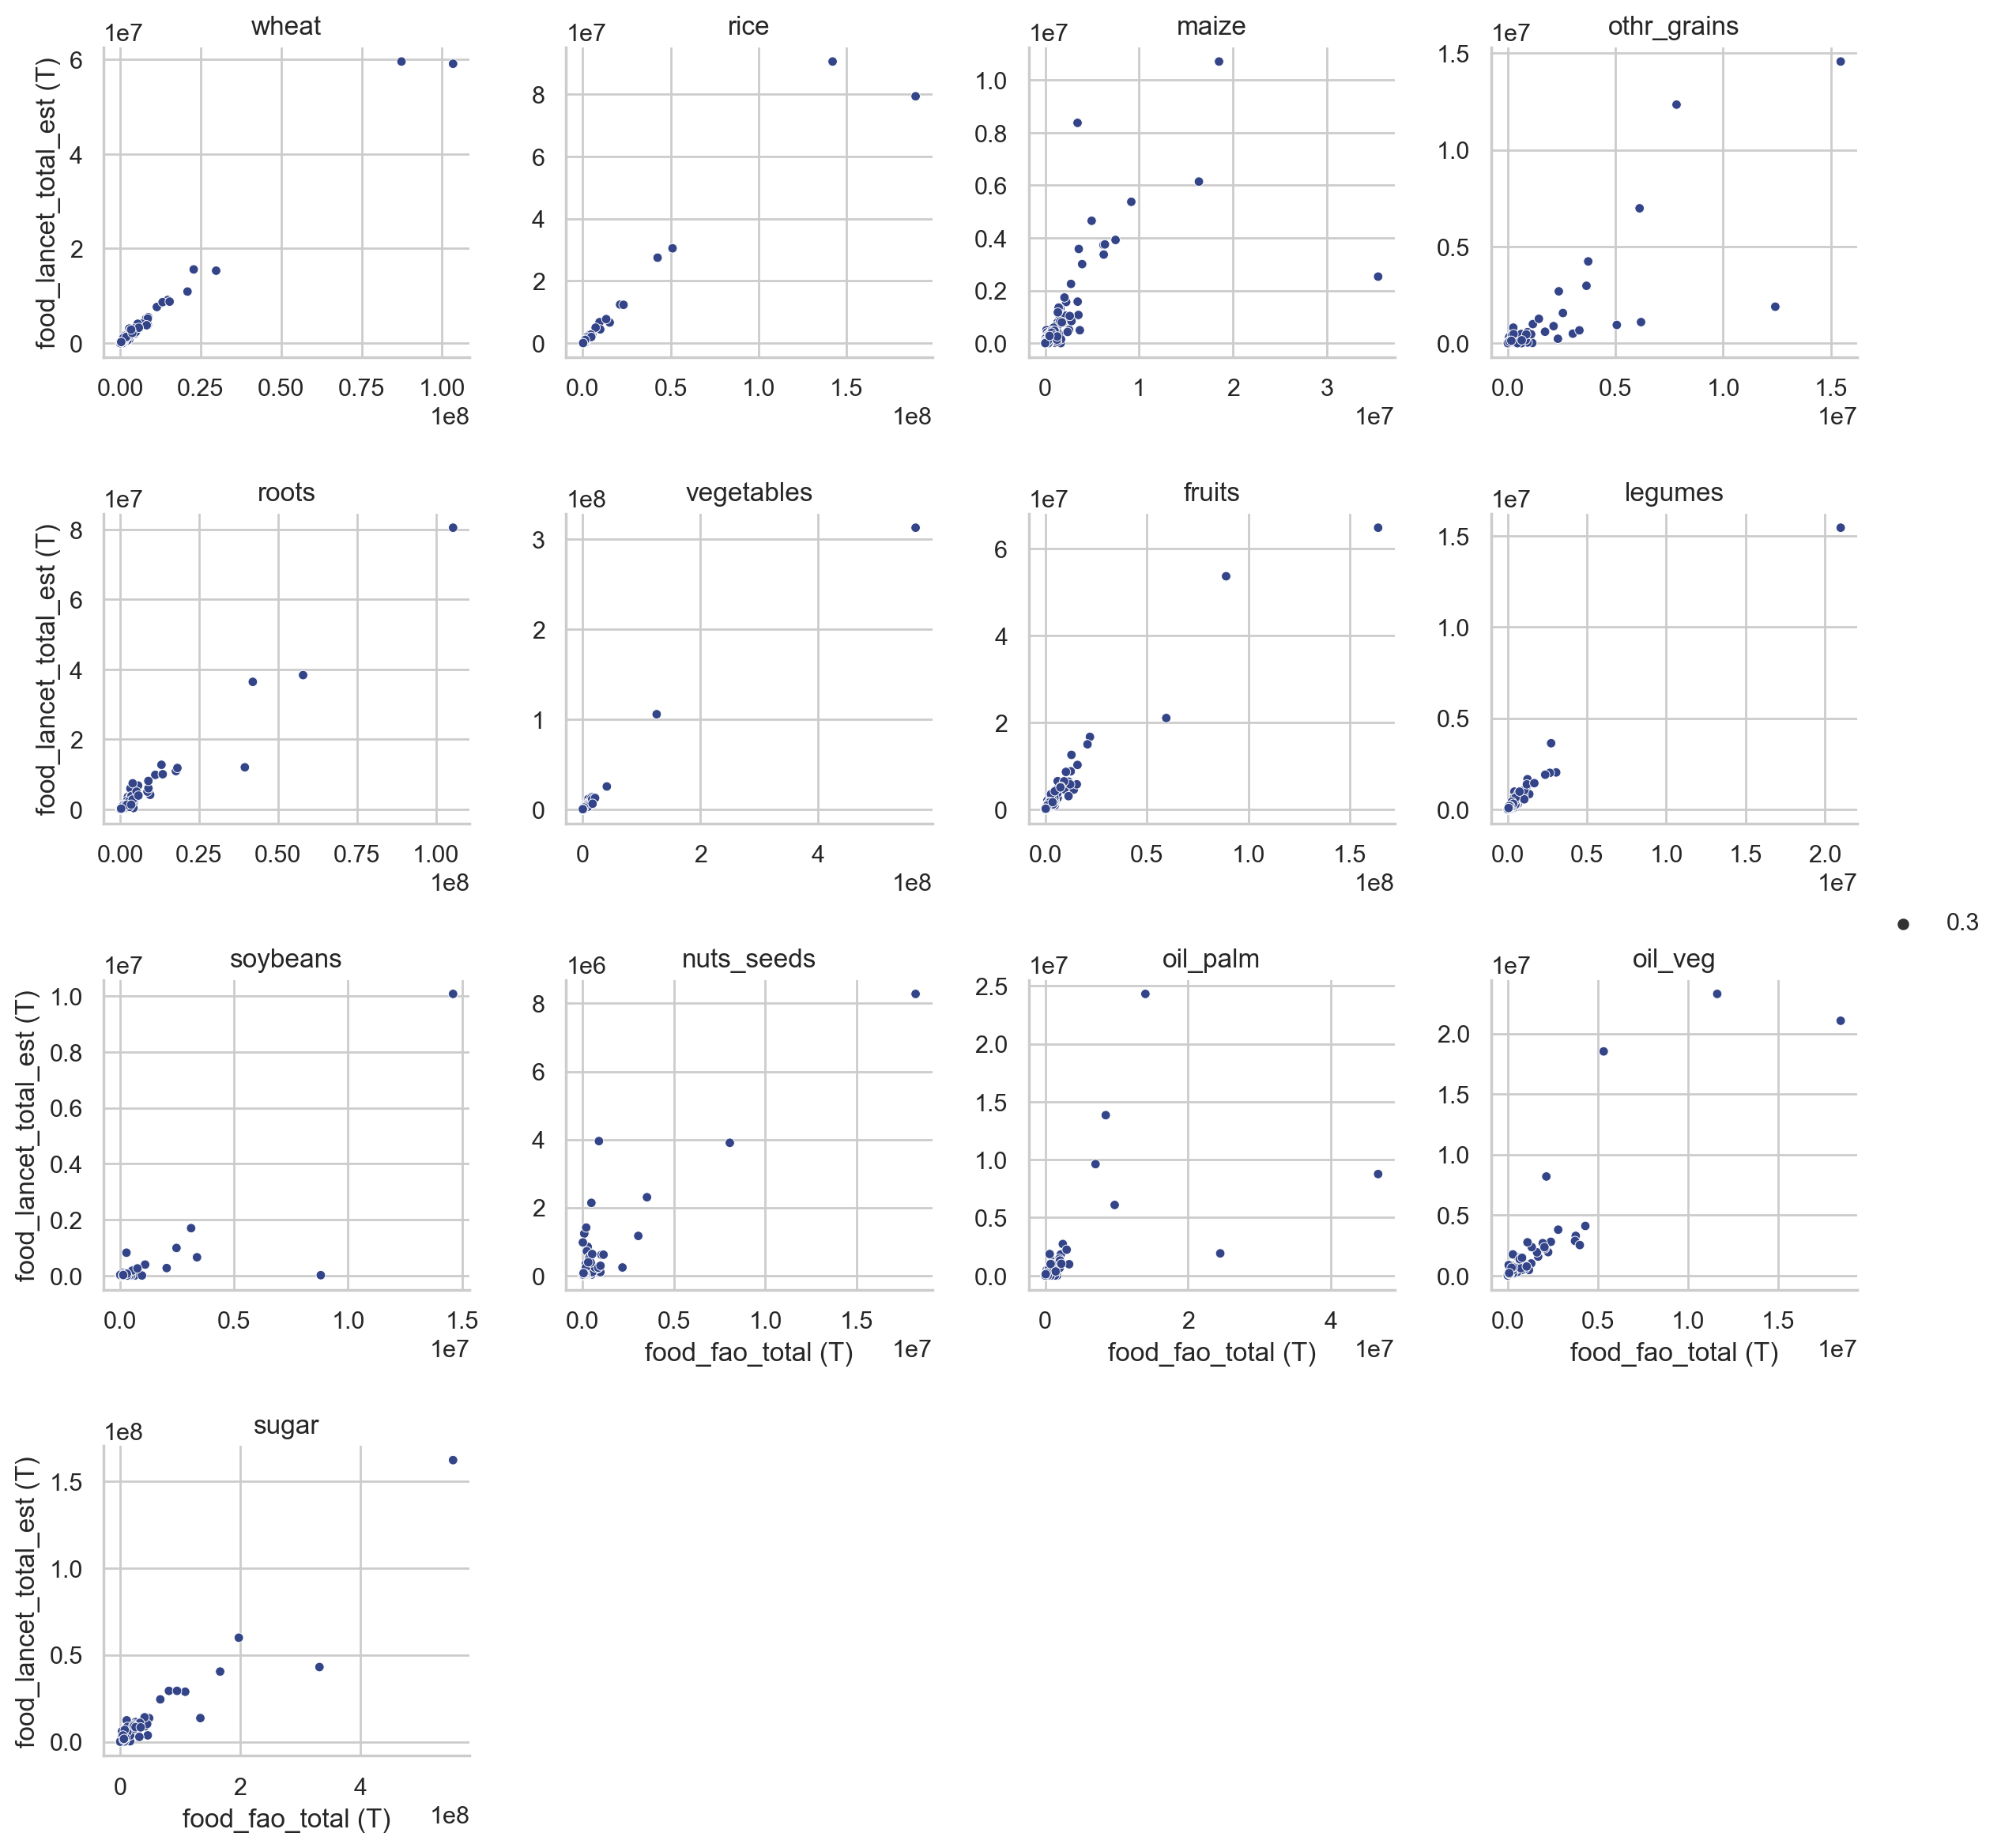

In [42]:
g = sns.relplot(
    data=df,
    x="food_fao_total", y="food_lancet_total_est", col="food_group",
    col_order=['wheat', 'rice', 'maize', 'othr_grains', 'roots', 'vegetables', 'fruits', 
               'legumes', 'soybeans', 'nuts_seeds', 'oil_palm', 'oil_veg', 'sugar'],
    col_wrap=4, 
    height=3, facet_kws=dict(sharex=False, sharey=False),
    color="#334488", size=0.3
)
g.set_titles(col_template="{col_name}")
g.set_ylabels('food_lancet_total_est (T)')
g.set_xlabels('food_fao_total (T)')

In [43]:
def get_corr(df, X, Y):
    return df[[X, Y]].corr()[X][Y]

df.groupby('food_group').apply(lambda g: get_corr(g, "food_fao_total", "food_lancet_total_est"))

food_group
fruits         0.967603
legumes        0.990860
maize          0.658145
nuts_seeds     0.889523
oil_palm       0.566082
oil_veg        0.901569
othr_grains    0.812887
rice           0.978297
roots          0.976858
soybeans       0.847960
sugar          0.951027
vegetables     0.993489
wheat          0.994423
dtype: float64

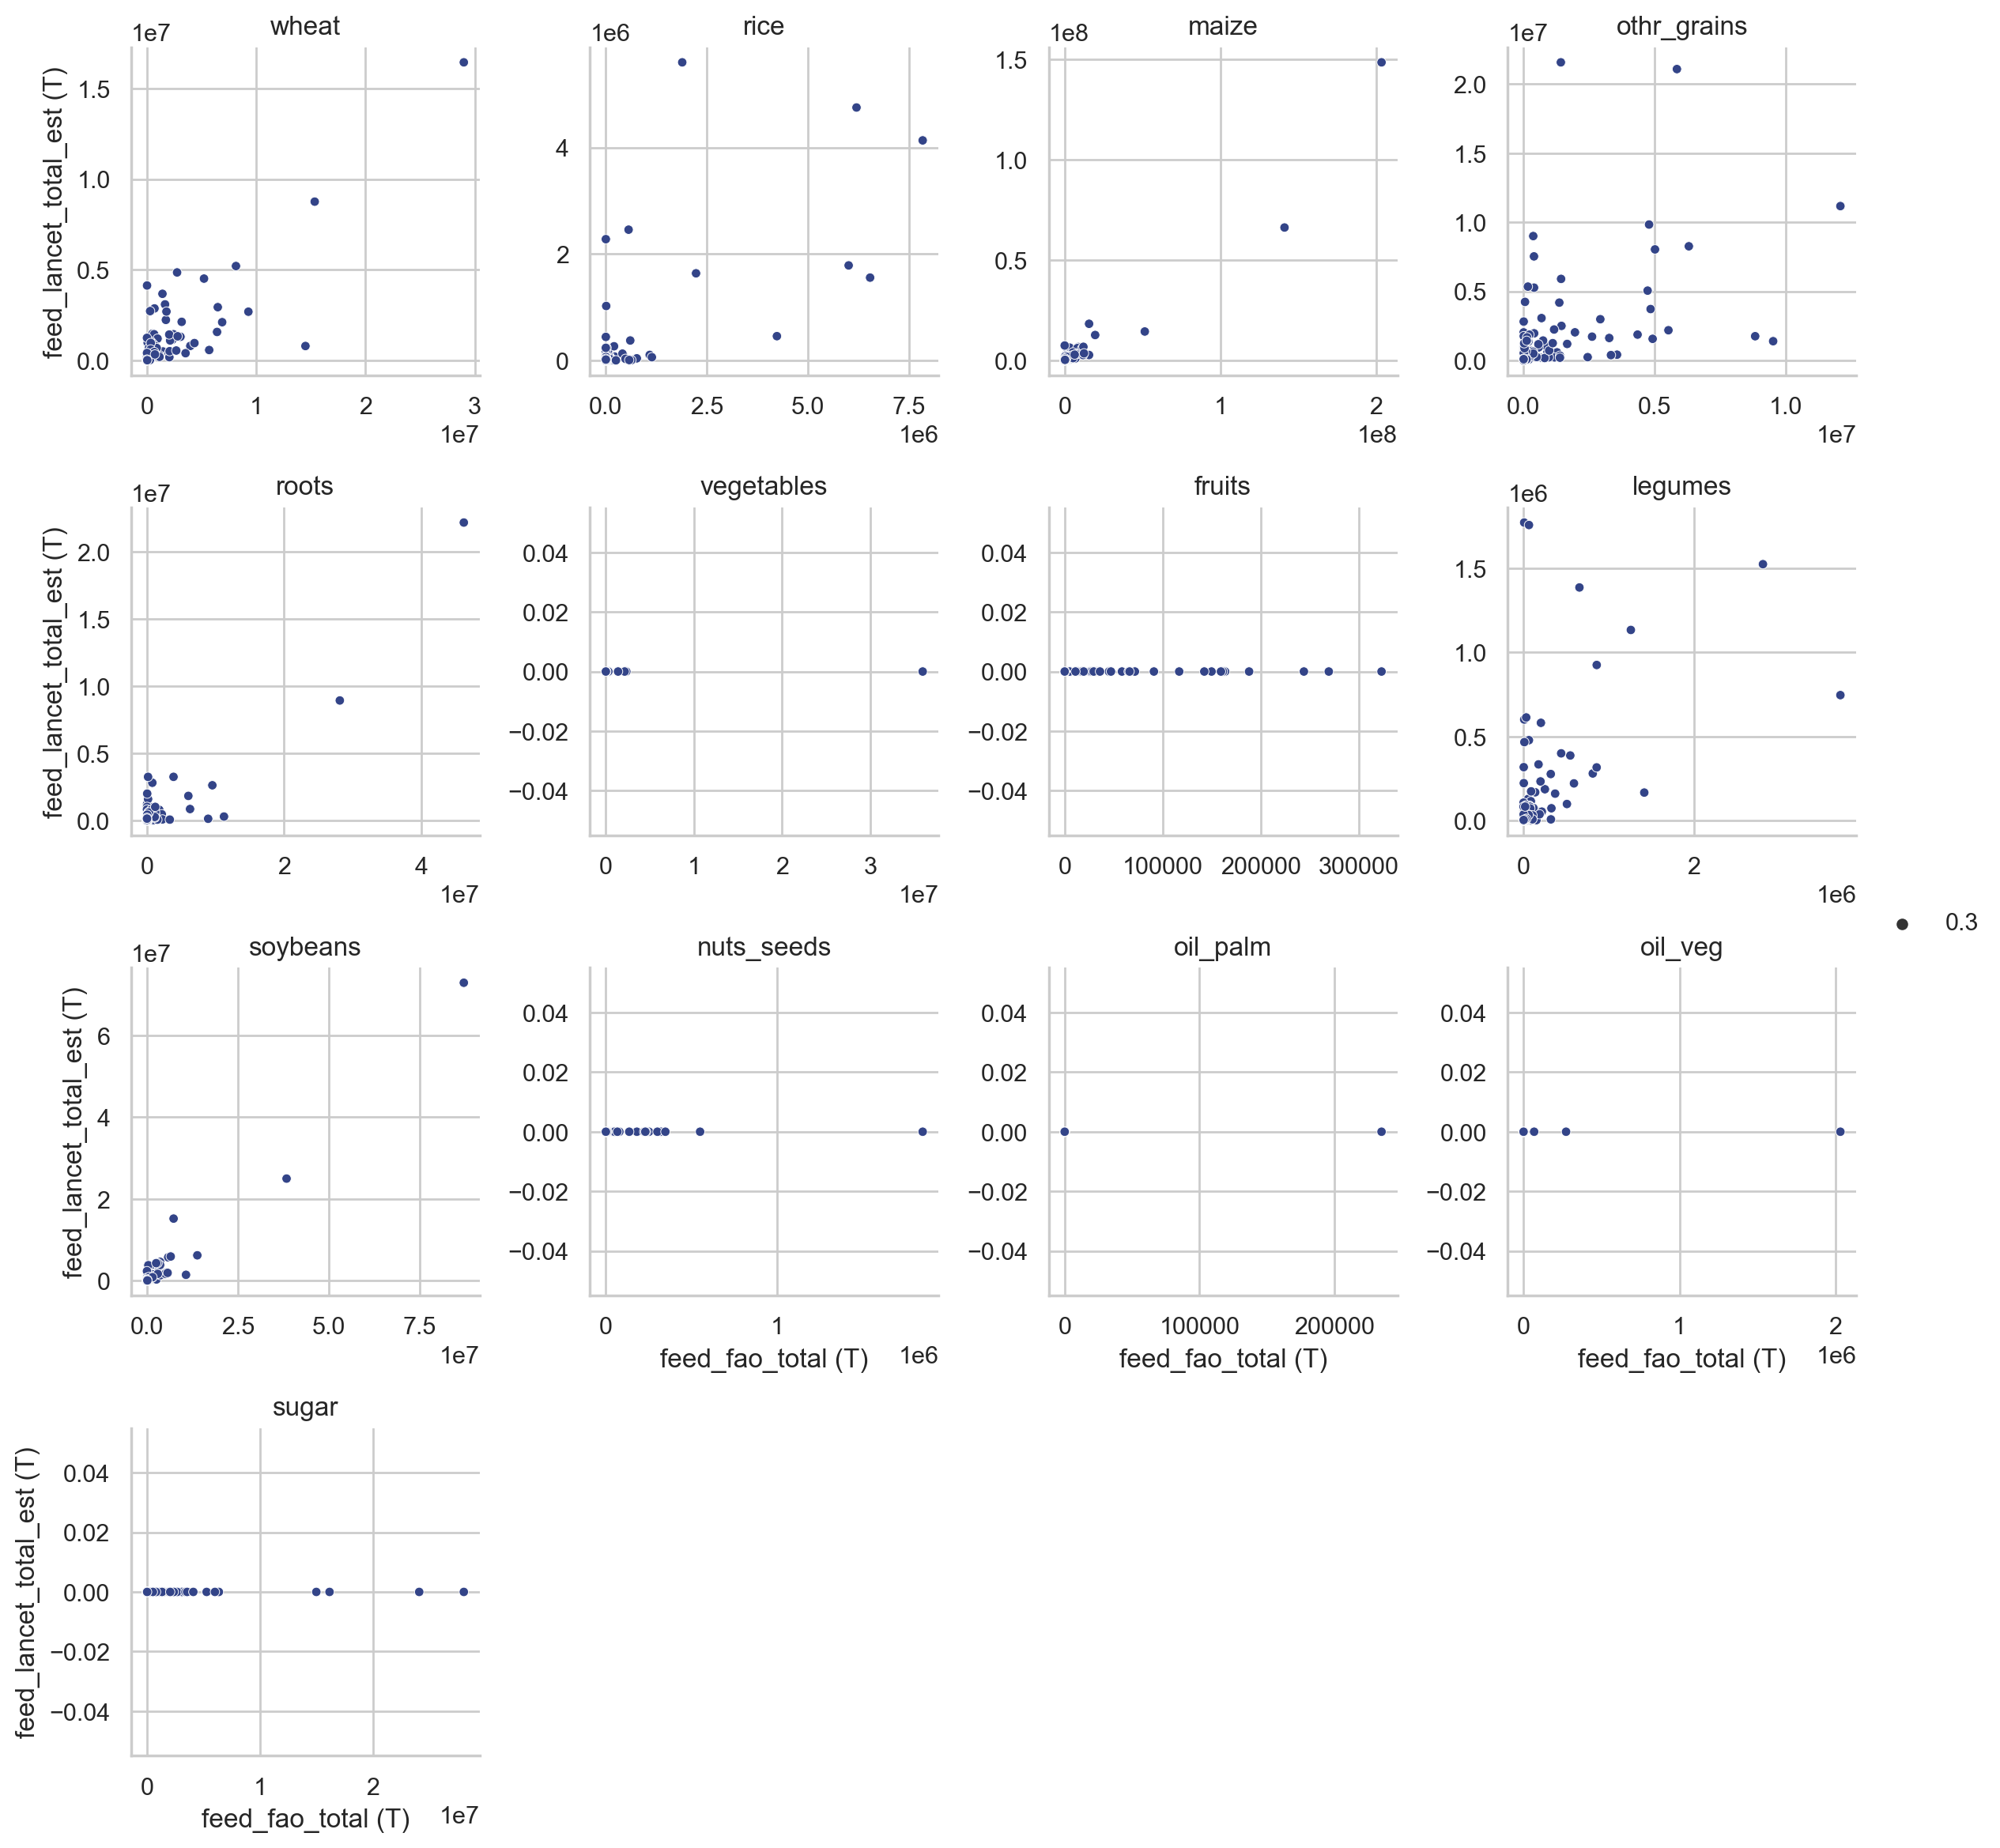

In [44]:
g = sns.relplot(
    data=df,
    x="feed_fao_total", y="feed_lancet_total_est", col="food_group",
    col_order=['wheat', 'rice', 'maize', 'othr_grains', 'roots', 'vegetables', 'fruits', 
               'legumes', 'soybeans', 'nuts_seeds', 'oil_palm', 'oil_veg', 'sugar'],
    col_wrap=4, 
    height=3, facet_kws=dict(sharex=False, sharey=False),
    color="#334488", size=0.3
)
g.set_titles(col_template="{col_name}")
g.set_ylabels('feed_lancet_total_est (T)')
g.set_xlabels('feed_fao_total (T)')

In [45]:
df.groupby('food_group').apply(lambda g: get_corr(g, "feed_fao_total", "feed_lancet_total_est"))

food_group
fruits              NaN
legumes        0.504765
maize          0.969394
nuts_seeds          NaN
oil_palm            NaN
oil_veg             NaN
othr_grains    0.483979
rice           0.702083
roots          0.921507
soybeans       0.977555
sugar               NaN
vegetables          NaN
wheat          0.837884
dtype: float64

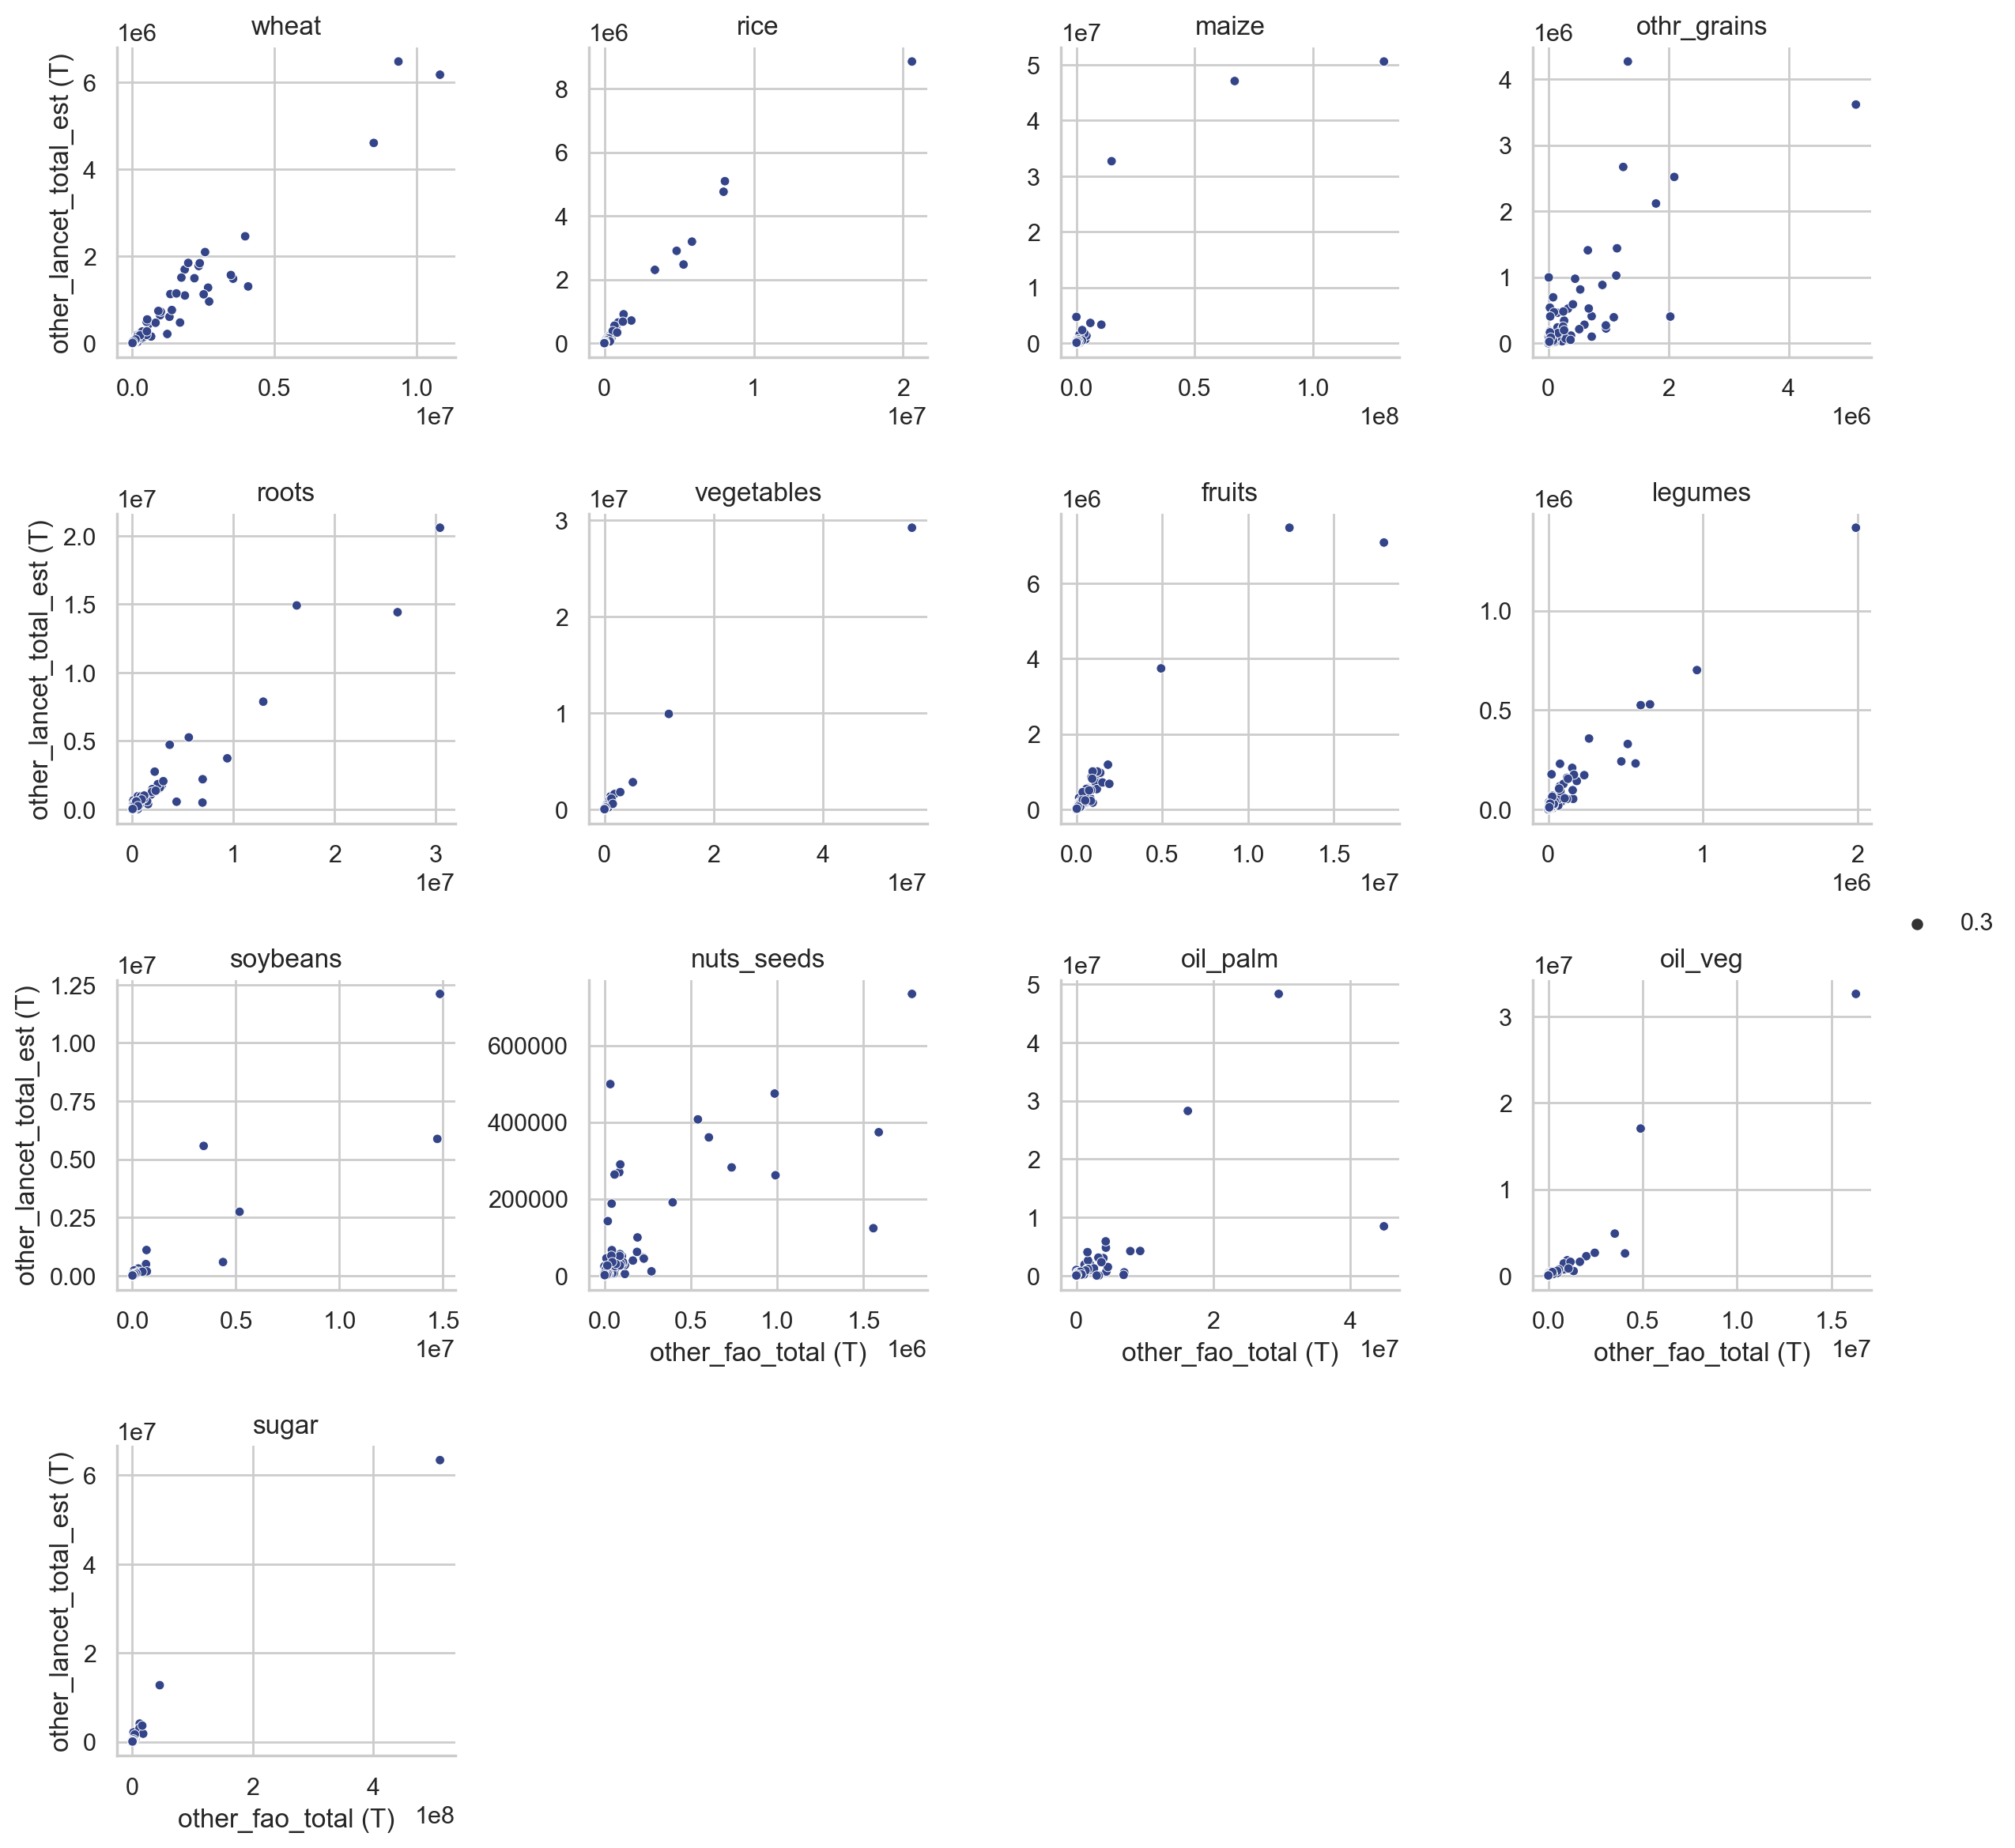

In [46]:
g = sns.relplot(
    data=df,
    x="other_fao_total", y="other_lancet_total_est", col="food_group",
    col_order=['wheat', 'rice', 'maize', 'othr_grains', 'roots', 'vegetables', 'fruits', 
               'legumes', 'soybeans', 'nuts_seeds', 'oil_palm', 'oil_veg', 'sugar'],
    col_wrap=4, 
    height=3, facet_kws=dict(sharex=False, sharey=False),
    color="#334488", size=0.3
)
g.set_titles(col_template="{col_name}")
g.set_ylabels('other_lancet_total_est (T)')
g.set_xlabels('other_fao_total (T)')

In [47]:
df.groupby('food_group').apply(lambda g: get_corr(g, "other_fao_total", "other_lancet_total_est"))

food_group
fruits         0.965977
legumes        0.972186
maize          0.904929
nuts_seeds     0.745522
oil_palm       0.695273
oil_veg        0.959581
othr_grains    0.783181
rice           0.984789
roots          0.961154
soybeans       0.912085
sugar          0.991698
vegetables     0.991676
wheat          0.974568
dtype: float64

In [48]:
# feed and other not estimated for other crop
# not sure if we should use other based on FAO or the one estimated with lancet data
cons_g.to_csv('../../OPSIS/Data/Future_production_demand_data/demand_scn_food_feed_other.csv', index=False)